In [ ]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense ,Input, LSTM, Concatenate, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import joblib
import datetime

Load data

In [ ]:
df = pd.read_csv('data/netstats_hourly_4_3.csv')

In [ ]:
df.head()

**Feature Creation**

In [ ]:
df['rx_gbs_delta'] = df.groupby('link_loc')['rx_gbs'].diff()

# Calculate tx_gbs_delta
df['tx_gbs_delta'] = df.groupby('link_loc')['tx_gbs'].diff()

# The first delta_delta value for each link_loc group will be NaN because there's no previous value to subtract from.
# You might want to fill these NaN values depending on your requirements, for example, with 0s:
df['rx_gbs_delta'] = df['rx_gbs_delta'].fillna(0)
df['tx_gbs_delta'] = df['tx_gbs_delta'].fillna(0)

In [ ]:
# ensure 'time' is a datetime64 type
df['time'] = pd.to_datetime(df['time'])

# Extract hour of day
df['hour_of_day'] = df['time'].dt.hour

# Extract day of the week (Monday=0, Sunday=6)
df['day_of_week'] = df['time'].dt.dayofweek

In [ ]:
# Encode 'hour_of_day' cyclically
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day']/24)

# Encode 'day_of_week' cyclically
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

In [ ]:
df.drop(columns=['hour_of_day','day_of_week'],inplace=True)

In [ ]:
# encode fields
enc = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')

ohefit = enc.fit(df[['link', 'location']])

joblib.dump(ohefit, './model/ohefit.save')

#ohetransform = enc.fit_transform(df[['link_loc']])
ohetransform = enc.fit_transform(df[['link', 'location']])

df_encoded = pd.concat([df,ohetransform],axis = 1).drop(columns= ['link', 'location'])

**Skipping scaling momentarily**

In [16]:
# scaling fields
# Selecting the columns to scale, which have 'delta' in their names
# features_to_scale = [col for col in df_encoded.columns if 'delta' in col]

# # Fitting the scaler on the selected features and transforming them
# scaler = StandardScaler()
# df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

# # Save the scaler to a file for later use
# joblib.dump(scaler, './model/scaler.save')

In [1]:
# df_encoded.iloc[:,10:].drop_duplicates().shape
df_encoded.T.iloc[:,:5]

NameError: name 'df_encoded' is not defined

### Model Architechture

![Model Architecture](assets/model_arch.png)

In [18]:
# generating the size of the inputs based on number of fields of each type
temporal_count = 0
num_non_temporal_features = 0
num_semi_temporal_features = 0
for col in list(df_encoded.drop(columns=['link_loc']).columns):
    if 'hour' in col or 'day' in col:
        num_semi_temporal_features +=1
    if 'link' in col or 'location' in col:
        num_non_temporal_features +=1
    if 'delta' in col:
        temporal_count +=1

**Model Inputs**

In [27]:
# variables
#window = 48 # historical or features
#horizon = 12 # forecast size
window = 24 # historical or features
horizon = 6 # forecast size

batch = 32

dense_size = 64
num_layers = 4

# layer_size = 64
# dense_layers_count =4

epochs = 100

**Training Data prep Functions**

In [20]:
df_encoded.shape

(17504, 22)

In [21]:
def split_feature_set(df_in):
    """ given a dataframe with a single site host combination will return 3 features sets"""
    # Temporal features
    temporal_features = df_in[['rx_gbs','rx_gbs_delta', 'tx_gbs','tx_gbs_delta']].values
    # Non-temporal features (one-hot encoded site and host)
    non_temporal_features_list = [col for col in df_in.columns if 'link' in col or 'location' in col]
    non_temporal_features = df_in[non_temporal_features_list].values
    # Semi-temporal features
    semi_temporal_features = df_in[['hour_sin', 'hour_cos', 'day_sin', 'day_cos']].values
    return temporal_features, non_temporal_features, semi_temporal_features

In [22]:
def data_split(xt, xnt, xst, yt, batch_size):
    split_size = int(len(xt) * 0.8)
    
    xt_train, xt_valid = xt[:split_size], xt[split_size:]
    xnt_train, xnt_valid = xnt[:split_size], xnt[split_size:]
    xst_train, xst_valid = xst[:split_size], xst[split_size:]
    yt_train, yt_valid = yt[:split_size], yt[split_size:]
    
    # Create datasets for the training and validation sets
    train_ds = tf.data.Dataset.from_tensor_slices(((xt_train, xnt_train, xst_train), yt_train)).batch(batch_size)
    valid_ds = tf.data.Dataset.from_tensor_slices(((xt_valid, xnt_valid, xst_valid), yt_valid)).batch(batch_size)
    return train_ds, valid_ds, xt_valid, xnt_valid, xst_valid, yt_valid

In [23]:
# Generate training set with features and labels (from time series data)
def window_gen(x_t,x_nt,x_st,window,horizon):
    xt,yt, xnt,xst = [],[],[],[]    
    for i in range(window,len(x_t)-horizon):
        xt.append(x_t[i-window:i,])
        xnt.append(x_nt[i,:])
        xst.append(x_st[i,:])
        yt.append(x_t[i:i+horizon,:2])
    return xt,xnt,xst,yt

In [24]:
# using root mean square error to punish model more heavily for missing spikes
@tf.keras.utils.register_keras_serializable()
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [25]:
def create_model(n_past, num_features, n_future, num_semi_temporal_features,num_non_temporal_features, lstm_units=64, non_temporal_size=50, semi_temporal_size=50, 
                 dense_layers=[50], activation='relu', dropout_rate=0.1):

    # Temporal features input
    temporal_input = Input(shape=(n_past, num_features))

    # LSTM branch for temporal features
    lstm_out = LSTM(units=lstm_units, return_sequences=False)(temporal_input)
    lstm_out = Dropout(dropout_rate)(lstm_out)

    # Non-temporal features input
    non_temporal_input = Input(shape=(num_non_temporal_features,))  
    non_temporal_branch = Dense(non_temporal_size, activation=activation)(non_temporal_input)
    non_temporal_branch = Dropout(dropout_rate)(non_temporal_branch)

    # Semi-temporal features input
    semi_temporal_input = Input(shape=(num_semi_temporal_features,))
    semi_temporal_branch = Dense(semi_temporal_size, activation=activation)(semi_temporal_input)
    semi_temporal_branch = Dropout(dropout_rate)(semi_temporal_branch)

    # Concatenate outputs
    combined = Concatenate()([lstm_out, non_temporal_branch, semi_temporal_branch])

    # Additional Dense layers as specified
    for layer_size in dense_layers:
        combined = Dense(layer_size, activation=activation)(combined)
        combined = Dropout(dropout_rate)(combined)

    # Final output layer
    final_output = Dense(n_future*2)(combined)  # 2 features
    final_output = Reshape((n_future, 2))(final_output)  # Reshape to [?, 12, 2]
    
    # Construct and compile the model
    model = Model(inputs=[temporal_input, non_temporal_input, semi_temporal_input], outputs=final_output)
    model.compile(optimizer='adam', loss=rmse)  # Adjust optimizer and loss as needed
    #model.compile(optimizer='adam', loss='mse')  # Adjust optimizer and loss as needed
    return model

In [28]:
# data build
xt,xst,xnt, yt = [],[],[],[]

for series in df_encoded.link_loc.unique():
    temp = df_encoded[df_encoded['link_loc'] == series].copy()
    # x_st = temp.drop(columns=['time','link_loc']).values[:,:4] # hour / day
    # x_nt = temp.drop(columns=['time','link_loc']).values[:,4:35] # site / host
    # x_t = temp.drop(columns=['time','link_loc']).values[:,35:] # site / host
    x_t, x_nt, x_st = split_feature_set(temp.drop(columns=['time','link_loc']))
    
    if len(xt) > 0: # check only scaled, assume it same for both
        xt_temp,xnt_temp,xst_temp, y_temp = window_gen(x_t,x_nt,x_st,window,horizon)
        for xt_array in xt_temp:
            xt.append(xt_array)
        
        for xnt_array in xnt_temp:
            xnt.append(xnt_array)
            
        for xst_array in xst_temp:
            xst.append(xst_array)
        
        for y_array in y_temp:
            yt.append(y_array) 
    else: 
     xt,xnt,xst, yt = window_gen(x_t,x_nt,x_st,window,horizon)

In [29]:
xt = np.array(xt)
xnt = np.array(xnt)
xst = np.array(xst)
yt = np.array(yt)

In [30]:
layers = [dense_size] * num_layers

In [31]:
model = create_model(window, 4, horizon, num_semi_temporal_features,num_non_temporal_features, dense_layers = layers)

2024-04-27 17:53:52.610943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 17:53:52.643521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 17:53:52.645668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [32]:
train_ds, valid_ds, xt_valid, xnt_valid, xst_valid, yt_valid = data_split(xt, xnt, xst, yt, batch)

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [34]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [35]:
start_time = time.time()
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[tensorboard_callback, early_stopping],  # Include both callbacks in the list
)
#model.fit(train_ds, epochs=epochs, validation_data=valid_ds,callbacks=[tensorboard_callback],)
# Stop the stopwatch and calculate the elapsed time
elapsed_time = time.time() - start_time

# Print or use the elapsed time
print(f"Training took {elapsed_time:.2f} seconds.")

Epoch 1/100


2024-04-27 17:54:01.306284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-04-27 17:54:02.690432: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdda42fad10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-27 17:54:02.690500: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 3g.40gb, Compute Capability 8.0
2024-04-27 17:54:02.707369: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-27 17:54:02.878637: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


426/426 [==============================] - 14s 19ms/step - loss: 2.3339 - val_loss: 3.1701
Epoch 2/100
426/426 [==============================] - 7s 16ms/step - loss: 1.9535 - val_loss: 2.7816
Epoch 3/100
426/426 [==============================] - 6s 15ms/step - loss: 1.8377 - val_loss: 2.5658
Epoch 4/100
426/426 [==============================] - 6s 15ms/step - loss: 1.7339 - val_loss: 2.4190
Epoch 5/100
426/426 [==============================] - 6s 14ms/step - loss: 1.7072 - val_loss: 2.4069
Epoch 6/100
426/426 [==============================] - 6s 13ms/step - loss: 1.6882 - val_loss: 2.2614
Epoch 7/100
426/426 [==============================] - 6s 14ms/step - loss: 1.6533 - val_loss: 2.2537
Epoch 8/100
426/426 [==============================] - 6s 14ms/step - loss: 1.6051 - val_loss: 2.1011
Epoch 9/100
426/426 [==============================] - 6s 14ms/step - loss: 1.6346 - val_loss: 2.0982
Epoch 10/100
426/426 [==============================] - 6s 14ms/step - loss: 1.5508 - val_los

In [36]:
# save model
model_path = './model/lstm_model.keras'  # Specifying the '.keras' extension
model.save(model_path)

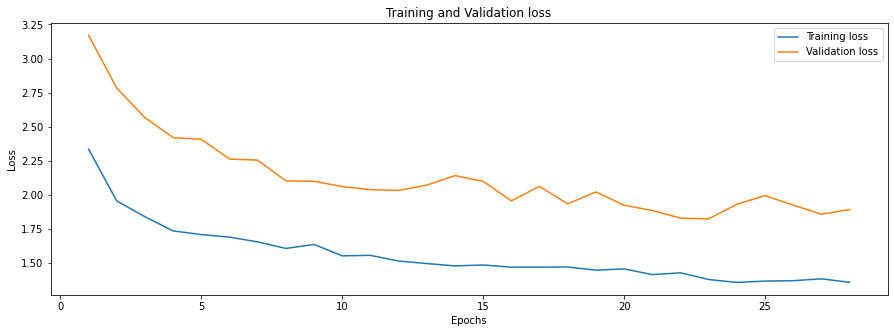

In [37]:

# Assuming 'mse' for training and 'val_mse' for validation are the correct keys
loss = history.history['loss']  # Training MSE
val_loss = history.history['val_loss']  # Validation MSE
epochs = range(1, len(loss) + 1)  # Adjusting epoch count to start from 1

# Plotting
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(epochs, loss, label='Training loss')
ax.plot(epochs, val_loss, label='Validation loss')
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

Review model predictions

In [39]:
valid_ds.shape

AttributeError: '_BatchDataset' object has no attribute 'shape'

In [40]:
predictions = model.predict(valid_ds)  # Adjust this if you need to predict on a specific subset

107/107 [==============================] - 1s 5ms/step


In [44]:
type(valid_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

In [45]:
xt_valid.shape

(3405, 24, 4)

In [48]:
xt_valid[0,:,:]

array([[ 0.32597324,  0.17041741,  0.32597324,  0.17041741],
       [ 0.60705299,  0.28107976,  0.60705299,  0.28107976],
       [ 0.85707848,  0.25002548,  0.85707848,  0.25002548],
       [ 0.72407652, -0.13300196,  0.72407652, -0.13300196],
       [ 0.89640499,  0.17232847,  0.89640499,  0.17232847],
       [ 0.97451403,  0.07810904,  0.97451403,  0.07810904],
       [ 0.86571264, -0.10880139,  0.86571264, -0.10880139],
       [ 0.84448217, -0.02123047,  0.84448217, -0.02123047],
       [ 0.84973504,  0.00525288,  0.84973504,  0.00525288],
       [ 0.62915166, -0.22058338,  0.62915166, -0.22058338],
       [ 0.52462665, -0.10452501,  0.52462665, -0.10452501],
       [ 0.28363623, -0.24099041,  0.28363623, -0.24099041],
       [ 0.23978037, -0.04385587,  0.23978037, -0.04385587],
       [ 0.22255682, -0.01722355,  0.22255682, -0.01722355],
       [ 0.23170773,  0.00915091,  0.23170773,  0.00915091],
       [ 0.20678879, -0.02491894,  0.20678879, -0.02491894],
       [ 0.20983229,  0.

In [42]:
predictions.shape

(3405, 6, 2)

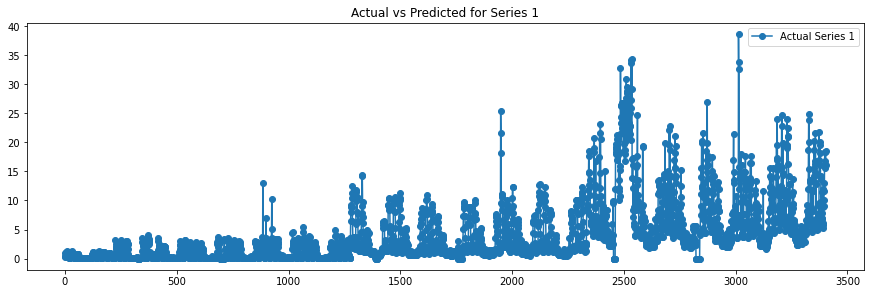

In [53]:
feature_indices = [0, 2]

# Extract the last time step data from x_valid for these two features
# We use [:, -1, feature_index] to get the last time step for all samples for each feature
actual_series_1 = xt_valid[:, -1, feature_indices[0]]
actual_series_2 = xt_valid[:, -1, feature_indices[1]]

# Extract corresponding predictions; assuming the predictions are in the same order
# We take all data points for each series; adjust if your layout is different
predicted_series_1 = predictions[:, :, 0].flatten()  # Flatten if you want a continuous line
predicted_series_2 = predictions[:, :, 1].flatten()

# Plotting
plt.figure(figsize=(15, 10))

# Plotting for the first series
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(actual_series_1, label='Actual Series 1', marker='o')
#plt.plot(predicted_series_1, label='Predicted Series 1', marker='x')
plt.title('Actual vs Predicted for Series 1')
plt.legend()

In [51]:
actual_series_1[:15]

array([0.23971553, 0.49118304, 0.90209074, 1.06001968, 1.03308827,
       0.87644806, 0.91977226, 1.1481537 , 1.33972486, 1.06402333,
       1.02744979, 0.44557878, 0.24108594, 0.28155165, 0.26108082])

In [52]:
predicted_series_1[:15]

array([0.40217215, 0.4822147 , 0.5637546 , 0.6392021 , 0.8006946 ,
       0.85857654, 0.49724865, 0.57694507, 0.64807403, 0.7061906 ,
       0.83499676, 0.8909936 , 0.7042841 , 0.75017196, 0.7950394 ],
      dtype=float32)

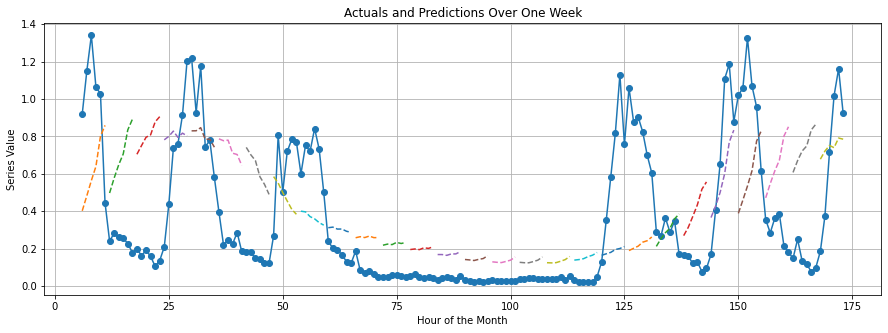

In [58]:

# Constants
HOURS_IN_WEEK = 168
START_HOUR = 6  # Starting from 6 hours before the week for the first prediction context
PRED_INTERVAL = 6
FORECAST_LENGTH = 6

# Sample data extraction
# Extract one week of actuals starting from 'START_HOUR'
actual_data = xt_valid[START_HOUR:START_HOUR + HOURS_IN_WEEK, -1, 0]  # Adjust the last index if using another feature

# Create a time axis for actual data
time_actual = np.arange(START_HOUR, START_HOUR + HOURS_IN_WEEK)

# Prepare the plot
plt.figure(figsize=(15, 5))
plt.plot(time_actual, actual_data, label='Actual Data', marker='o')

# Plotting predictions made every 6 hours
for i in range(0, HOURS_IN_WEEK, PRED_INTERVAL):
    # Prediction start and end points
    pred_start = START_HOUR + i #+ HOURS_IN_WEEK
    pred_end = pred_start + FORECAST_LENGTH
    
#     print('pred_start',pred_start)
#     print('pred_end',pred_end)
    
    # Time axis for predictions
    time_pred = np.arange(pred_start, pred_end)
    
    # Extract predictions (reshape if necessary and select the correct indices)
    predictions_plot = predictions[i//PRED_INTERVAL, :, 0].flatten()  # Adjust the index for different series
    
    # Plot predictions
    plt.plot(time_pred, predictions_plot, label=f'Prediction from {pred_start}', linestyle='--')

# Configurations for better visualization
plt.title('Actuals and Predictions Over One Week')
plt.xlabel('Hour of the Month')
plt.ylabel('Series Value')
#plt.legend()
plt.grid(True)
plt.show()